In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import torch
from torchvision import transforms
from torchvision import datasets
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.datasets import ImageFolder
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#Transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-10, +10)),
    # transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

valid_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])


In [5]:
# Directories for train, valid, test datasets
train_dir="/content/drive/MyDrive/bird_dataset/train"
valid_dir="/content/drive/MyDrive/bird_dataset/valid"
test_dir="/content/drive/MyDrive/bird_dataset/test"
data_train=ImageFolder(train_dir, train_transform)
data_valid=ImageFolder(valid_dir, valid_transform)
data_test=ImageFolder(test_dir, test_transform)



In [6]:
data_train.class_to_idx

{'ALBATROSS': 0,
 'AMERICAN AVOCET': 1,
 'BLACK SWAN': 2,
 'CACTUS WREN': 3,
 'CHINESE BAMBOO PARTRIDGE': 4,
 'COMMON STARLING': 5,
 'CUBAN TROGON': 6,
 'GREAT ARGUS': 7,
 'JAVA SPARROW': 8,
 'PUFFIN': 9,
 'WILD TURKEY': 10,
 'ZEBRA DOVE': 11}

In [7]:
train_loader=DataLoader(data_train, batch_size=16, shuffle=True)
valid_loader=DataLoader(data_valid, batch_size=16)
test_loader=DataLoader(data_test)

In [8]:
len(train_loader)

121

In [9]:
class VGG19(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2)
                             )
    self.conv2=nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2)
                             )
    self.conv3=nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2)
                             )
    self.conv4=nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2)
                             )
    self.conv5=nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding="same"),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2)
                             )
    self.conn=nn.Sequential(nn.Flatten(),
                            nn.Linear(25088, 4096),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096, 4096),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 12))
  def forward(self, x):
    x=self.conv1(x)
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)
    x=self.conn(x)
    return x



In [10]:
device

'cuda'

In [11]:
from torch import optim
model1=VGG19().to(device)
losss=nn.CrossEntropyLoss()
model_optim=optim.Adam(model1.parameters(), lr=1e-4) #Optimizer and loss functions can be changed

In [14]:
model1

VGG19(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_

In [15]:
#Accuracy function
def multiclass_accuracy(y_pred,y_true):
  top_p,top_class = y_pred.topk(1,dim = 1)
  equals = top_class == y_true.view(*top_class.shape)
  return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
# train function
from tqdm import tqdm
def train(model, trainloader, optimizer, loss_func):
  total_loss=0
  total_accuracy=0
  model.train()
  for i, data in enumerate(tqdm(trainloader)):
    image, label= data
    image=image.to(device)
    label=label.to(device)
    optimizer.zero_grad()
    pred=model(image)
    loss=loss_func(pred, label)
    total_loss+=loss.item()
    loss.backward()
    optimizer.step()
    accuracy=multiclass_accuracy(pred, label)
    total_accuracy+=accuracy
  return total_loss/len(trainloader), total_accuracy/len(trainloader)


In [ ]:
#Eval function
def evall(model, loader, loss_func):
  total_loss=0
  total_accuracy=0
  model.eval()
  for i, data in enumerate(tqdm(loader)):
    image, label= data
    image=image.to(device)
    label=label.to(device)
    pred=model(image)
    loss=loss_func(pred, label)
    total_loss+=loss.item()
    accuracy=multiclass_accuracy(pred, label)
    total_accuracy+=accuracy
  return total_loss/len(loader), total_accuracy/len(loader)

In [ ]:
#Training the model
best_loss=np.Inf
train_losss=[]
valid_losss=[]
for i in range(10):
  train_loss, train_accuracy=train(model1, train_loader, model_optim, losss)
  print(f"Current epoch:{i},  train loss:{train_loss},  train accuracy:{train_accuracy}")
  train_losss.append(train_loss)
  valid_loss, valid_accuracy=evall(model1, valid_loader, losss)
  print(f"Current epoch:{i},  valid loss:{valid_loss},  valid accuracy:{valid_accuracy}")
  valid_losss.append(valid_loss)
  if valid_loss < best_loss:
    torch.save(model1.state_dict(), "/content/drive/MyDrive/classification_models/best_model.pt")
    best_loss=valid_loss




100%|██████████| 121/121 [00:41<00:00,  2.93it/s]


Current epoch:0,  train loss:2.034946258403053,  train accuracy:0.26308539509773254


100%|██████████| 4/4 [00:00<00:00,  8.19it/s]


Current epoch:0,  valid loss:1.9656965732574463,  valid accuracy:0.2135416716337204


100%|██████████| 121/121 [00:41<00:00,  2.93it/s]


Current epoch:1,  train loss:1.945036333454542,  train accuracy:0.2875344455242157


100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Current epoch:1,  valid loss:1.8825314939022064,  valid accuracy:0.2552083432674408


100%|██████████| 121/121 [00:41<00:00,  2.91it/s]


Current epoch:2,  train loss:1.8111342034064049,  train accuracy:0.332988977432251


100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


Current epoch:2,  valid loss:1.6103256940841675,  valid accuracy:0.3854166567325592


100%|██████████| 121/121 [00:41<00:00,  2.90it/s]


Current epoch:3,  train loss:1.6664390278256629,  train accuracy:0.39910468459129333


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Current epoch:3,  valid loss:1.506591096520424,  valid accuracy:0.4791666567325592


100%|██████████| 121/121 [00:41<00:00,  2.93it/s]


Current epoch:4,  train loss:1.440831093748739,  train accuracy:0.46074381470680237


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


Current epoch:4,  valid loss:1.3073748797178268,  valid accuracy:0.5


100%|██████████| 121/121 [00:41<00:00,  2.90it/s]


Current epoch:5,  train loss:1.28060631564826,  train accuracy:0.522382915019989


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Current epoch:5,  valid loss:1.298604667186737,  valid accuracy:0.5572916865348816


100%|██████████| 121/121 [00:41<00:00,  2.92it/s]


Current epoch:6,  train loss:1.138402062506715,  train accuracy:0.571969747543335


100%|██████████| 4/4 [00:00<00:00,  8.13it/s]


Current epoch:6,  valid loss:1.1756762713193893,  valid accuracy:0.6041666865348816


100%|██████████| 121/121 [00:41<00:00,  2.92it/s]


Current epoch:7,  train loss:1.0068981100705043,  train accuracy:0.6439393758773804


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


Current epoch:7,  valid loss:1.0623609870672226,  valid accuracy:0.65625


100%|██████████| 121/121 [00:41<00:00,  2.92it/s]


Current epoch:8,  train loss:0.8854049454050615,  train accuracy:0.6782024502754211


100%|██████████| 4/4 [00:00<00:00,  7.74it/s]


Current epoch:8,  valid loss:1.0821405053138733,  valid accuracy:0.7291666865348816


100%|██████████| 121/121 [00:41<00:00,  2.95it/s]


Current epoch:9,  train loss:0.8491155278584188,  train accuracy:0.6942148804664612


100%|██████████| 4/4 [00:00<00:00,  7.79it/s]


Current epoch:9,  valid loss:1.022240698337555,  valid accuracy:0.75


In [ ]:
def loss_curve(epochs, train_losss, valid_losss):
  epochs = list(range(1, epochs + 1))
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[1:], train_losss[1:], label="Training Loss")
  plt.plot(epochs[1:], valid_losss[1:], label="Validation Loss")
  plt.legend()
  merged_losses = train_losss[1:] + valid_losss[1:]
  highest_loss = max(merged_losses)
  lowest_loss = min(merged_losses)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.title('loss curve')
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()

1.0959208055961231


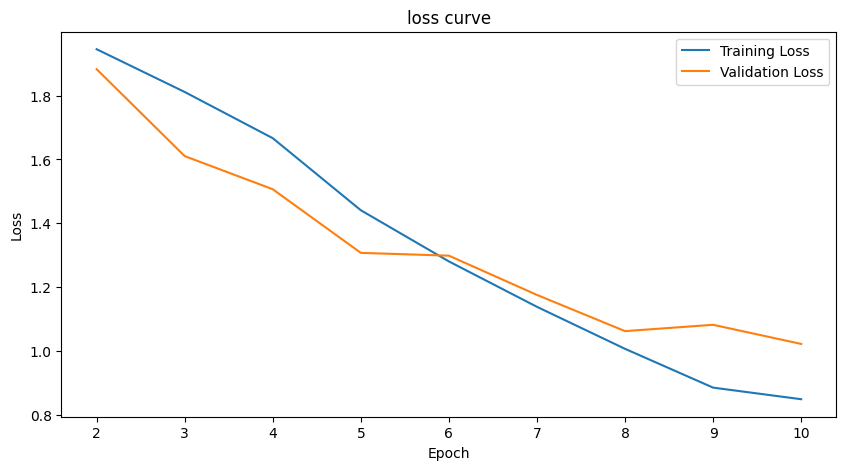

In [ ]:
loss_curve(10, train_losss, valid_losss)

In [ ]:
test_loss, test_accuracy=evall(model1, test_loader, losss)
print(f"Test loss:{test_loss},  Test accuracy:{test_accuracy}")

100%|██████████| 60/60 [00:01<00:00, 53.34it/s]

Test loss:0.5986063380936836,  Test accuracy:0.7666666507720947
